## SOLUTION
#### The code base of our proposed methodology is given in this Jupyter Notebook.

**You may refer model training directly and load `processed_usecase_1.csv` to get the embeddings for evaluation.**

First we install all the dependencies of our code.

In [ ]:
!pip install -r requirements.txt

Import the necessary libraries and modules that would be used later.

In [2]:
import pandas as pd 
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import gc 
import numpy as np
from tqdm import tqdm
from bertviz import head_view
import re

Load the csv file of the given dataset into a dataframe

In [ ]:
!gzip -d usecase_1_.csv.gz
csv=pd.read_csv('usecase_1_.csv')

Analyze the dataset for important statistics such as dimensions, columns, type of data, etc

In [6]:
csv

,Unnamed: 0,Unnamed: 0.1,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,...,Study Design,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents
0,0,1,NCT03302091,A Study in People With Normal Kidney Function ...,https://clinicaltrials.gov/study/NCT03302091,NaN,COMPLETED,The primary objective of the current study is ...,YES,Renal Insufficiency|Healthy,...,Allocation: NON_RANDOMIZED|Intervention Model:...,1386-0002|2017-002180-18,2017-10-17,2018-08-16,2018-08-16,2017-10-04,2021-06-04,2021-06-04,"CRS Clinical Research Services Kiel GmbH, Kiel...","Study Protocol, https://cdn.clinicaltrials.gov..."
1,1,2,NCT01948791,16w Interventional Study on Titration and Dose...,https://clinicaltrials.gov/study/NCT01948791,INSTINCT,COMPLETED,To investigate the efficacy of Exelon capsule ...,YES,Alzheimer's Disease,...,Allocation: NA|Intervention Model: SINGLE_GROU...,CENA713BCN05,2014-08,2015-09,2015-09,2013-09-24,2017-02-13,2017-02-13,"Novartis Investigative Site, Beijing, 100053, ...",NaN
2,2,5,NCT04621591,Case Series With Saneso 360° Gastroscope,https://clinicaltrials.gov/study/NCT04621591,NaN,COMPLETED,To confirm the procedural performance of the S...,NO,EGD Procedure,...,Allocation: NA|Intervention Model: SINGLE_GROU...,SAN360UGICL,2020-08-01,2020-08-30,2020-09-09,2020-11-09,NaN,2020-11-10,"Valley Endoscopy Center, Saint Clairsville, Oh...",NaN
3,3,6,NCT03130491,European Study Evaluating the EMBLOK Embolic P...,https://clinicaltrials.gov/study/NCT03130491,NaN,COMPLETED,The primary objective is to evaluate the perfo...,NO,Aortic Valve Disease,...,Allocation: NA|Intervention Model: SINGLE_GROU...,CLP002-2016,2017-03-08,2021-11-01,2022-01-28,2017-04-26,NaN,2024-03-05,"Hospital San Donato, Milan, Milano, 20097, Ita...",NaN
4,4,8,NCT01580891,Evaluate the Clinical Equivalence of Two Nafti...,https://clinicaltrials.gov/study/NCT01580891,NaN,COMPLETED,The objective of this study is to evaluate the...,NO,Tinea Pedis,...,Allocation: RANDOMIZED|Intervention Model: PAR...,NTFC 1105.0,2012-05,2013-03,2013-07,2012-04-19,NaN,2014-05-06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117975,117975,150114,NCT00706654,Intramuscular Depot Formulation of Aripiprazol...,https://clinicaltrials.gov/study/NCT00706654,ASPIRE,COMPLETED,The purpose of the this trial is to evaluate t...,YES,Schizophrenia,...,Allocation: RANDOMIZED|Intervention Model: PAR...,31-07-247,2008-09,2012-08,2012-08,2008-06-27,2013-08-14,2013-08-14,"Cerritos, California, 90703, United States|Esc...",NaN
117976,117976,150117,NCT05098054,A Study of Soticlestat in Adults With Liver Fa...,https://clinicaltrials.gov/study/NCT05098054,NaN,COMPLETED,The main aim is to check the effect of a singl...,YES,Hepatic Impairment|Healthy Volunteers,...,Allocation: NON_RANDOMIZED|Intervention Model:...,TAK-935-1010|2021-006373-29,2021-10-29,2022-05-31,2022-06-07,2021-10-28,2024-02-02,2024-02-02,"Velocity, Edgewater, Florida, 32132, United St...","Study Protocol, https://cdn.clinicaltrials.gov..."
117977,117977,150119,NCT06352554,Susceptibility Testing In Neisseria Gonorrhoea...,https://clinicaltrials.gov/study/NCT06352554,STING,NOT_YET_RECRUITING,This study aims to validate a novel antibiotic...,NO,Diagnosis|Gonorrhea|Resistance Bacterial,...,Observational Model: |Time Perspective: p,2023/ETH02474:STING|224842/Z/21/Z|75A50122C00028,2024-04-08,2024-12-30,2025-01-30,2024-04-08,NaN,2024-04-09,NaN,NaN
117978,117978,150120,NCT00710554,A Study of Sativex® for Pain Relief of Periphe...,https://clinicaltrials.gov/study/NCT00710554,NaN,COMPLETED,The purpose of this study is to evaluate the e...,YES,Pain|Peripheral Neuropathy,...,Allocation: RANDOMIZED|Intervention Model: PAR...,GWCL0405,2005-08,2006-10,2006-10,2008-07-04,2012-09-14,2023-05-03,"Pain Clinic Office, Gartnavel General Hospital...",NaN


In [43]:
# Observing the NaN values in Phases
csv['Phases'].head(50)

0            PHASE1
1            PHASE4
2               NaN
3               NaN
4            PHASE1
5            PHASE3
6               NaN
7     PHASE1|PHASE2
8            PHASE4
9            PHASE1
10           PHASE2
11              NaN
12           PHASE3
13    PHASE2|PHASE3
14           PHASE2
15           PHASE3
16           PHASE2
17           PHASE2
18              NaN
19              NaN
20              NaN
21           PHASE2
22              NaN
23           PHASE2
24           PHASE1
25           PHASE1
26           PHASE4
27           PHASE1
28           PHASE4
29           PHASE1
30    PHASE2|PHASE3
31           PHASE2
32    PHASE2|PHASE3
33              NaN
34           PHASE2
35           PHASE3
36              NaN
37              NaN
38              NaN
39              NaN
40           PHASE3
41           PHASE1
42              NaN
43           PHASE3
44              NaN
45           PHASE1
46    PHASE1|PHASE2
47              NaN
48           PHASE1
49           PHASE2


In [44]:
csv.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'NCT Number', 'Study Title', 'Study URL',
       'Acronym', 'Study Status', 'Brief Summary', 'Study Results',
       'Conditions', 'Interventions', 'Primary Outcome Measures',
       'Secondary Outcome Measures', 'Other Outcome Measures', 'Sponsor',
       'Collaborators', 'Sex', 'Age', 'Phases', 'Enrollment', 'Funder Type',
       'Study Type', 'Study Design', 'Other IDs', 'Start Date',
       'Primary Completion Date', 'Completion Date', 'First Posted',
       'Results First Posted', 'Last Update Posted', 'Locations',
       'Study Documents'],
      dtype='object')

In [45]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117980 entries, 0 to 117979
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  117980 non-null  int64  
 1   Unnamed: 0.1                117980 non-null  int64  
 2   NCT Number                  117980 non-null  object 
 3   Study Title                 117980 non-null  object 
 4   Study URL                   117980 non-null  object 
 5   Acronym                     24116 non-null   object 
 6   Study Status                117980 non-null  object 
 7   Brief Summary               117980 non-null  object 
 8   Study Results               117980 non-null  object 
 9   Conditions                  117950 non-null  object 
 10  Interventions               112324 non-null  object 
 11  Primary Outcome Measures    114903 non-null  object 
 12  Secondary Outcome Measures  93200 non-null   object 
 13  Other Outcome 

In [46]:
csv.describe()

,Unnamed: 0,Unnamed: 0.1,Enrollment
count,117980.000000,117980.000000,1.161470e+05
mean,58989.500000,75024.005620,4.487728e+03
std,34058.036717,43318.321717,5.930507e+05
min,0.000000,1.000000,0.000000e+00
25%,29494.750000,37511.500000,3.000000e+01
50%,58989.500000,75004.500000,7.700000e+01
75%,88484.250000,112567.250000,2.420000e+02
max,117979.000000,150121.000000,1.888141e+08


In [47]:
csv.dtypes

Unnamed: 0                      int64
Unnamed: 0.1                    int64
NCT Number                     object
Study Title                    object
Study URL                      object
Acronym                        object
Study Status                   object
Brief Summary                  object
Study Results                  object
Conditions                     object
Interventions                  object
Primary Outcome Measures       object
Secondary Outcome Measures     object
Other Outcome Measures         object
Sponsor                        object
Collaborators                  object
Sex                            object
Age                            object
Phases                         object
Enrollment                    float64
Funder Type                    object
Study Type                     object
Study Design                   object
Other IDs                      object
Start Date                     object
Primary Completion Date        object
Completion D

#### **Exploratory Data Analysis**

A count plot is a visualization tool used to display the frequency of each category in a categorical variable. The categorical variable we have chosen to show below is 'Phases'.

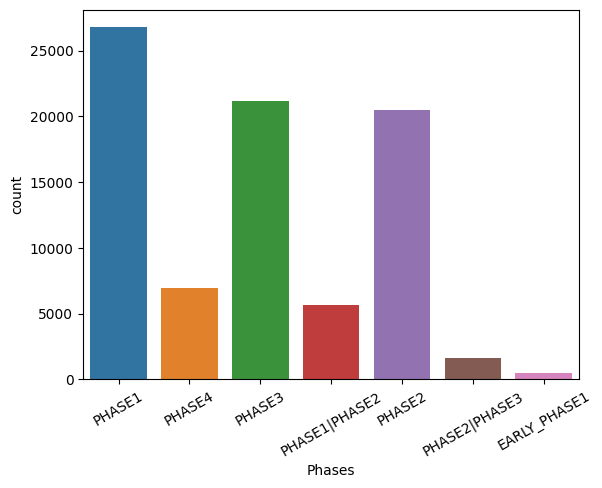

In [48]:
ax=sns.countplot(data=csv, x="Phases",orient="y")
ax.tick_params(axis='x', rotation=30)

Keep only the useful columns in the dataframe and drop all others

In [49]:
csv = csv.drop(['Unnamed: 0.1','Unnamed: 0','Study URL',
       'Acronym', 'Study Status', 'Brief Summary', 'Study Results',
         'Other Outcome Measures', 'Sponsor',
       'Collaborators', 'Sex', 'Age', 'Enrollment', 'Funder Type',
       'Study Type', 'Study Design', 'Other IDs', 'Start Date',
       'Primary Completion Date', 'Completion Date', 'First Posted',
       'Results First Posted', 'Last Update Posted', 'Locations',
       'Study Documents'], axis=1)

In [50]:
csv.columns

Index(['NCT Number', 'Study Title', 'Conditions', 'Interventions',
       'Primary Outcome Measures', 'Secondary Outcome Measures', 'Phases'],
      dtype='object')

In order to join the criteria column from the text file 'eligibilities.txt', make sure that the column with which the rows are getting mapped from one csv file to another have the same name in both files. For this, rename the 'NCT Number' column in the DataFrame csv to 'nct_id'

In [51]:
csv.rename(columns={'NCT Number': 'nct_id'}, inplace=True)

Move the 'eligibilities.txt' file to this directory and load it.

In [60]:
eligibilities_file = "eligibilities.txt" # Replace with path as per user's system
eligibilities_df = pd.read_csv(eligibilities_file, delimiter="|", encoding="utf-8")  


In [61]:
eligibilities_df.columns

Index(['id', 'nct_id', 'sampling_method', 'gender', 'minimum_age',
       'maximum_age', 'healthy_volunteers', 'population', 'criteria',
       'gender_description', 'gender_based', 'adult', 'child', 'older_adult'],
      dtype='object')

In [62]:
eligibilities_df.columns = eligibilities_df.columns.str.strip()

Extract the required columns from 'eligibilities.txt'

In [63]:
eligibilities_df=eligibilities_df[['nct_id', 'criteria']]

In [64]:
eligibilities_df

,nct_id,criteria
0,NCT05050916,* INCLUSION CRITERIA:~In order to be eligible ...
1,NCT01092156,Inclusion Criteria:~* Pregnant women who inten...
2,NCT01218256,Inclusion Criteria:~* type 2 diabetes mellitus...
3,NCT03240432,Inclusion Criteria:~To be eligible for the stu...
4,NCT04348578,"Inclusion Criteria:~* necrotic, single root te..."
...,...,...
502296,NCT02723058,Inclusion Criteria:~* Mothers who are residing...
502297,NCT05832216,Inclusion Criteria:~* Diagnosis of aplastic an...
502298,NCT05199597,Inclusion Criteria:~* 18 years and older~Exclu...
502299,NCT01583283,Inclusion Criteria:~* Relapsed or Relapsed/Ref...


Merge the criteria column from the text file

In [65]:
merged_df = eligibilities_df.merge(csv, on='nct_id', how='right')


In [66]:
merged_df.head(5)

,nct_id,criteria,Study Title,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Phases
0,NCT03302091,Inclusion Criteria:~* Despite of moderate rena...,A Study in People With Normal Kidney Function ...,Renal Insufficiency|Healthy,DRUG: BI 1467335,Area Under the Concentration-time Curve of BI ...,Area Under the Concentration-time Curve of BI ...,PHASE1
1,NCT01948791,Key Inclusion Criteria:~* Have a diagnosis of ...,16w Interventional Study on Titration and Dose...,Alzheimer's Disease,DRUG: ENA713,Mean Change From Baseline in the Alzheimer's D...,Change From Baseline in the Alzheimer's Diseas...,PHASE4
2,NCT04621591,Inclusion Criteria:~* 18 -74 years of age~* Wi...,Case Series With Saneso 360° Gastroscope,EGD Procedure,DEVICE: Saneso 360° gastroscope,"Successful EGD, Procedure success is assessed ...",Endoscopist qualitative rating of the Saneso 3...,NaN
3,NCT03130491,Inclusion Criteria: Subject is between 18 and ...,European Study Evaluating the EMBLOK Embolic P...,Aortic Valve Disease,PROCEDURE: Transcatheter Aortic Valve Replacem...,"Performance Endpoint, successful insertion, pl...","Safety Endpoint (Rate of MACCE), Rate of MACCE...",NaN
4,NCT01580891,"Inclusion Criteria:~* Male or non-pregnant, no...",Evaluate the Clinical Equivalence of Two Nafti...,Tinea Pedis,DRUG: Naftifine HCl Cream 1%|DRUG: Naftin® (Na...,"Therapeutic Cure, Patients with both mycologic...",NaN,PHASE1


Analyze the lengths of criteria

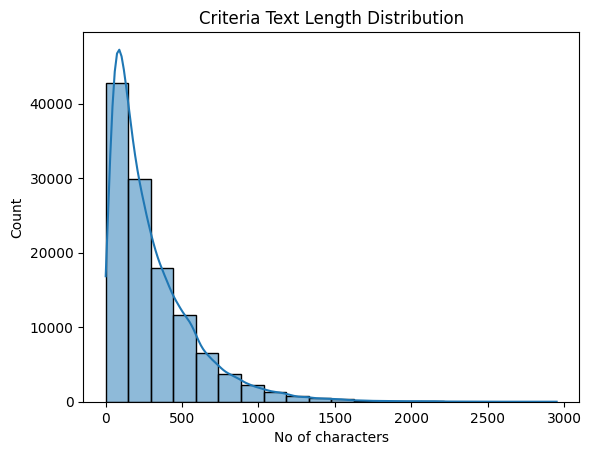

In [77]:
a=list(merged_df['criteria'].apply(lambda x: len(str(x).split())))
sns.histplot(a, bins=20, kde=True)
plt.title("Criteria Text Length Distribution")
plt.xlabel("No of characters")
plt.show()

Most models have a maximum token limit of 512. As seen in the histogram above, many entries have more than 512 characters. This is the reason why we have used a sliding window in our tokenizer while creating embeddings later.

#### **Data Pre-Processing**

The preprocessing workflow filters the criteria for clinically relevant terms, numerical values, and measurement units using **NER (Named Entity Recognition)**. A custom **Hunspell dictionary** (`en_med_glut.dic`) is loaded to identify medical terms, while **Regex** patterns detect numerical tokens and units. The text in the criteria column is tokenized, cleaned, and processed row by row. The criteria column in particular was selected because of the relatively higher word length, as noted in the graph above.

In [ ]:
def load_hunspell_dict(dic_file):
    terms = set()
    with open(dic_file, "r") as file:
        for line in file:
            # Remove any suffix after a "/" (e.g., POS tags in Hunspell files) and normalize the term
            normalized_term = re.sub(r"/.*$", "", line.strip()) 
            terms.add(normalized_term.lower())  
    return terms

def preprocess_text(text):
    text_lower = text.lower()
    text_no_possessive = re.sub(r"\'s\b", "", text_lower) # Remove apostrophes ('s)
    text_cleaned = re.sub(r"[^\w\s]", "", text_no_possessive) # Remove punctuation
    return text, text_cleaned  

def tokenize_text(text):
    return text.split()

def is_numerical_token(token):
    # Match integers, decimals, and scientific notation numbers
    return re.match(r"^\d+(\.\d+)?(e[+-]?\d+)?$", token) is not None

def is_unit_token(token):
    # Set of common medical and scientific units
    units = {
        "mg", "g", "kg", "mcg", "µg", "ng", "pg","ml", "l", "dl", "ul", "nl", "pl","mm", "cm", "m", "km", "µm", "nm", "pm","mmhg", "atm", "pa", "kpa", "hpa", "bar",
        "mol", "mmol", "µmol", "nmol", "pmol", "/l", "/dl", "/ml", "/µl","°c", "°f", "k","%","bpm", "iu", "meq", "sbp", "dbp", "cfu", "dpi", "uo",
    }
    return token.lower() in units

def ner_with_dictionary(text):
    hunspell_dict = load_hunspell_dict("static/others/en_med_glut.dic")
    original_text, text_cleaned = preprocess_text(text)
    tokens = tokenize_text(original_text)  
    tokens_cleaned = tokenize_text(text_cleaned)  

    entities = []
    for i, (token, token_cleaned) in enumerate(zip(tokens, tokens_cleaned)):
        if token_cleaned in hunspell_dict:
            entities.append((token, "Clinical Term"))
        elif is_numerical_token(token_cleaned):
            entities.append((token, "Numerical Term"))
        elif is_unit_token(token_cleaned):
            entities.append((token, "Unit Term"))

    return entities

# Create a copy of the dataset to avoid modifying the original (optional)
df = merged_df.copy()

columns = ['criteria']
a = 0

for column in columns:
    a += 1
    b = 0  
    # Fill missing values in the column with an empty string and convert to string type
    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)
    
    def process_row(row):
        global b 
        results = ner_with_dictionary(row) # Perform NER on the row text
        b += 1  
        print(f"Processing row {b} in column {column}")
        entities = [entity for entity, label in results]  
        return " ".join(entities)  

    # Create a new column with processed strings
    df[f'processed_{column}'] = df[column].apply(process_row)

df.to_csv('processed_usecase_1.csv')


In [71]:
print(df[['criteria', 'processed_criteria']].head())

                                            criteria  \
0  Inclusion Criteria:~* Despite of moderate rena...   
1  Key Inclusion Criteria:~* Have a diagnosis of ...   
2  Inclusion Criteria:~* 18 -74 years of age~* Wi...   
3  Inclusion Criteria: Subject is between 18 and ...   
4  Inclusion Criteria:~* Male or non-pregnant, no...   

                                  processed_criteria  
0  Inclusion Criteria : ~ * Despite moderate rena...  
1  Key Inclusion Criteria : ~ * Have diagnosis de...  
2  Inclusion Criteria : ~ * 18 -74 year age~ * Wi...  
3  Inclusion Criteria : Subject 18 90 year age.Su...  
4  Inclusion Criteria : ~ * Male non-pregnant , n...  


#### **Model Training**



**Choice of Model**:-ClinicalBERT is a domain-specific variation of BERT, pre-trained on large-scale clinical text data, such as electronic health records (EHRs). It outperforms other NLP techniques in semantic similarity tasks, which are closely related to trial matching. The attention mechanism present in the model enables it to grasp nuanced relationships in clinical trial matching, and also helps in easy visualization, useful for understanding and explaining the suggested similar clinical trials.

Load the tokenizer and model of ClinicalBERT 



### Workflow of the Code (Ladder Format)

1. **Data Preparation:**
   - Dataset creation:
     - Original text pairs
     - Augmented text pairs (e.g., reversing word order)
   - Tokenization:
     - Texts are tokenized
     - Padding to prepare input tensors  
 

2. **Model Setup:**
   - **Projection Head**:
     - Maps CLS token embeddings into a lower-dimensional space  


3. **Training Loop:**
   - For each batch:
     - Extract embeddings for original text
     - Extract embeddings for augmented text
   - Average embeddings across different text fields:
     - Criteria
     - Conditions
     - Interventions  
 

4. **Combine Embeddings:**
   - Concatenate embeddings of original and augmented pairs
   - Create positive and negative pairs for contrastive learning  


5. **Loss Calculation:**
   - Compute NT-Xent loss:
     - Maximize similarity for positive pairs
     - Minimize similarity for negative pairs
     - Apply temperature scaling  
  

6. **Optimization:**
   - Use AdamW optimizer
   - Perform backpropagation to update model parameters  


7. **Repeat:**
   - Continue training for multiple epochs  


In [ ]:
!gzip -d processed_usecase_1.csv.gz
df=pd.read_csv('processed_usecase_1.csv')

In [78]:
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
base_model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

Some weights of the model checkpoint at medicalai/ClinicalBERT were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Normalized Temperature-Scaled Cross-Entropy Loss (NT-Xent Loss)**

The `nt_xent_loss` function computes the loss used for contrastive learning. It measures the similarity between embeddings of original and augmented texts using cosine similarity and applies temperature scaling to sharpen the contrast between positive and negative pairs. 

The **Normalized Temperature-scaled Cross-Entropy Loss (NT-Xent)** is defined as:

![Sample Image](/mnt/DATA/Dhanvin/Novartis/static/images/nt-xent.png)


---

Key steps:
- Compute cosine similarity matrix.
- Apply masks for positive (same text, original vs. augmented) and negative pairs (different texts).
- Calculate the loss using the ratio of positive similarity to negative similarity.


In [1]:
def nt_xent_loss(embeddings, temperature=0.07):
    """Normalized temperature-scaled cross-entropy loss."""
    batch_size = embeddings.size(0) // 2
    sim_matrix = cosine_similarity(embeddings.cpu().detach().numpy())
    sim_matrix = torch.tensor(sim_matrix).to(embeddings.device)

    pos_mask = torch.eye(batch_size, device=embeddings.device).repeat(2, 2).bool()
    neg_mask = ~pos_mask

    exp_sim = torch.exp(sim_matrix / temperature)
    pos_sim = exp_sim * pos_mask
    neg_sim = exp_sim * neg_mask

    loss = -torch.log(pos_sim.sum(dim=1) / neg_sim.sum(dim=1))
    return loss.mean()

# Tokenize data
def tokenize_texts(texts,max_length=512):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

**Projection Head for Contrastive Learning**

The `ProjectionHead` class is defined to project the CLS token embeddings from the base model into a lower-dimensional space using:
- A linear layer to reduce dimensions.
- ReLU activation for non-linearity.
- Another linear layer to obtain the final projected embeddings.

In [ ]:
data = df
data.fillna("",inplace=True)

# Define a simple projection head for contrastive learning
class ProjectionHead(nn.Module):
    def __init__(self, base_model, embedding_dim=768, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.base_model = base_model
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        projected = self.projection(cls_embedding)
        return projected

# Initialize model with projection head
model = ProjectionHead(base_model)
for param in model.base_model.parameters():
    param.requires_grad = True # Set to True for adjustable hyperparameters in base model
model.train()

**Data Augmentation**

Simple text augmentations are performed for the following columns:
- `processed_criteria`
- `Phases`
- `Conditions`
- `Interventions`

Each text is reversed (e.g., `x.split()[::-1]`) to generate augmented versions.

**Contrastive Dataset**

The `ContrastiveDataset` class:
- Accepts a DataFrame containing both original and augmented texts.
- Stores them as pairs for training.
- Returns original and augmented text pairs during iteration.


In [ ]:
data['augmented_text_criteria'] = data['processed_criteria'].apply(lambda x: " ".join(x.split()[::-1]))  # Simple augmentation for title
data['augmented_text_Phases'] = data['Phases'].apply(lambda x: " ".join(x.split()[::-1]))  # Simple augmentation for phases
data['augmented_text_Conditions'] = data['Conditions'].apply(lambda x: " ".join(x.split()[::-1]))  # Simple augmentation for conditions
data['augmented_text_Interventions'] = data['Interventions'].apply(lambda x: " ".join(x.split()[::-1]))  # Simple augmentation for interventions

# Define dataset and dataloader
class ContrastiveDataset(Dataset):
    ''' 
    '''
    def __init__(self, df):
        self.texts = df[['processed_criteria', 'Phases', 'Conditions', 'Interventions']].values
        self.augmented_texts = df[['augmented_text_criteria', 'augmented_text_Phases', 'augmented_text_Conditions', 'augmented_text_Interventions']].values

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        texts = list(self.texts[idx])  
        augmented_texts = list(self.augmented_texts[idx]) 
        return texts, augmented_texts


dataset = ContrastiveDataset(data)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

**Training Loop**

In [ ]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 5
batch_size=2

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(dataloader):

        texts, augmented_texts = batch

        # Tokenize inputs
        tokenized_original_criteria = tokenize_texts([texts[0][i] for i in range(batch_size)])
        tokenized_original_phases = tokenize_texts([texts[1][i] for i in range(batch_size)])
        tokenized_original_conditions = tokenize_texts([texts[2][i] for i in range(batch_size)])
        tokenized_original_interventions = tokenize_texts([texts[3][i] for i in range(batch_size)])

        tokenized_augmented_criteria = tokenize_texts([augmented_texts[0][i] for i in range(batch_size)])
        tokenized_augmented_phases = tokenize_texts([augmented_texts[0][i] for i in range(batch_size)])
        tokenized_augmented_conditions = tokenize_texts([augmented_texts[0][i] for i in range(batch_size)])
        tokenized_augmented_interventions = tokenize_texts([augmented_texts[0][i] for i in range(batch_size)])
        
        # Forward pass for original texts
        embeddings_criteria = model(
            input_ids=tokenized_original_criteria['input_ids'],
            attention_mask=tokenized_original_criteria['attention_mask']
        )
        embeddings_phases = model(
            input_ids=tokenized_original_phases['input_ids'],
            attention_mask=tokenized_original_phases['attention_mask']
        )
        embeddings_conditions = model(
            input_ids=tokenized_original_conditions['input_ids'],
            attention_mask=tokenized_original_conditions['attention_mask']
        )
        embeddings_interventions = model(
            input_ids=tokenized_original_interventions['input_ids'],
            attention_mask=tokenized_original_interventions['attention_mask']
        )

        # Forward pass for augmented texts
        embeddings_aug_criteria = model(
            input_ids=tokenized_augmented_criteria['input_ids'],
            attention_mask=tokenized_augmented_criteria['attention_mask']
        )
        embeddings_aug_phases = model(
            input_ids=tokenized_augmented_phases['input_ids'],
            attention_mask=tokenized_augmented_phases['attention_mask']
        )
        embeddings_aug_conditions = model(
            input_ids=tokenized_augmented_conditions['input_ids'],
            attention_mask=tokenized_augmented_conditions['attention_mask']
        )
        embeddings_aug_interventions = model(
            input_ids=tokenized_augmented_interventions['input_ids'],
            attention_mask=tokenized_augmented_interventions['attention_mask']
        )

        # Combine embeddings by averaging
        embeddings_original = torch.mean(torch.stack([embeddings_criteria, embeddings_phases, embeddings_conditions, embeddings_interventions]), dim=0)
        embeddings_augmented = torch.mean(torch.stack([embeddings_aug_criteria, embeddings_aug_phases, embeddings_aug_conditions, embeddings_aug_interventions]), dim=0)

        # Combine original and augmented embeddings
        embeddings = torch.cat([embeddings_original, embeddings_augmented], dim=0)

        # Compute loss
        loss = nt_xent_loss(embeddings)

        # Backward pass
        optimizer.zero_grad()
        loss.requires_grad=True
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


#### **Embedding Generation**

Compute embeddings for long text columns in a DataFrame using a sliding window approach. Tokenize the text, extract embeddings from trained model, and aggregate them using mean pooling. The embeddings are computed for multiple columns in chunks to handle memory constraints efficiently. For this purpose, gc library is used.

In [ ]:
!gzip -d processed_usecase_1.csv.gz
df=pd.read_csv('processed_usecase_1.csv')

In [83]:
def encode_long_text(text, tokenizer, model, max_length=512, stride=256):

    if not isinstance(text, str) or text.strip() == '':
        return None

    # Tokenize with sliding window
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, 
                       max_length=max_length, stride=stride, return_overflowing_tokens=True)

    embeddings = []
    with torch.no_grad():
        for input_ids in inputs['input_ids']:
            outputs = model.base_model(input_ids=input_ids.unsqueeze(0), output_attentions=True)
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().squeeze().numpy()  
            embeddings.append(cls_embedding)

    # Aggregate embeddings (e.g., mean pooling)
    final_embedding = np.mean(embeddings, axis=0)
    return final_embedding

def safe_encode(text, tokenizer, model, embedding_size=768): # embedding_size should match the embeddings generated by the model 
    embedding = encode_long_text(text, tokenizer, model)
    if embedding is None:
        return np.zeros(embedding_size)  # Replace None with zero vector
    else:
        return embedding

# Split the dataframe into 20 chunks
chunk_size = 5899  
chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

start_index = 0  
df['embedding_1'] = np.nan
df['embedding_2'] = np.nan
df['embedding_3'] = np.nan
df['embedding_4'] = np.nan

for temp, chunk in tqdm(enumerate(chunks)):  
    print(f"Processing Chunk {temp + 1}/{len(chunks)}...")

    # Compute embeddings for each column
    embedding_1 = chunk['processed_criteria'].apply(lambda x: safe_encode(x, tokenizer, model))
    embedding_2 = chunk['Phases'].apply(lambda x: safe_encode(x, tokenizer, model))
    embedding_3 = chunk['processed_Interventions'].apply(lambda x: safe_encode(x, tokenizer, model))
    embedding_4 = chunk['processed_Conditions'].apply(lambda x: safe_encode(x, tokenizer, model))

    # Assign embeddings back to the original DataFrame
    df.loc[chunk.index, 'embedding_1'] = embedding_1
    df.loc[chunk.index, 'embedding_2'] = embedding_2
    df.loc[chunk.index, 'embedding_3'] = embedding_3
    df.loc[chunk.index, 'embedding_4'] = embedding_4
    gc.collect()

0it [00:00, ?it/s]

Processing Chunk 1/20...


1it [25:30, 1530.34s/it]

Processing Chunk 2/20...


2it [49:55, 1491.72s/it]

Processing Chunk 3/20...


3it [1:14:30, 1484.33s/it]

Processing Chunk 4/20...


4it [1:38:16, 1461.17s/it]

Processing Chunk 5/20...


5it [2:02:40, 1462.46s/it]

Processing Chunk 6/20...


6it [2:26:41, 1455.14s/it]

Processing Chunk 7/20...


7it [2:51:15, 1461.21s/it]

Processing Chunk 8/20...


8it [3:15:47, 1464.55s/it]

Processing Chunk 9/20...


9it [3:41:00, 1479.63s/it]

Processing Chunk 10/20...


10it [4:06:57, 1503.66s/it]

Processing Chunk 11/20...


11it [4:32:14, 1507.64s/it]

Processing Chunk 12/20...


12it [4:57:16, 1506.07s/it]

Processing Chunk 13/20...


13it [5:21:29, 1490.02s/it]

Processing Chunk 14/20...


14it [5:46:01, 1484.57s/it]

Processing Chunk 15/20...


15it [6:09:59, 1470.46s/it]

Processing Chunk 16/20...


16it [6:34:17, 1466.76s/it]

Processing Chunk 17/20...


17it [6:59:29, 1480.36s/it]

Processing Chunk 18/20...


18it [7:24:15, 1481.98s/it]

Processing Chunk 19/20...


19it [7:48:34, 1475.00s/it]

Processing Chunk 20/20...


20it [8:13:01, 1479.08s/it]


In [84]:
df[['embedding_1','embedding_2','embedding_3','embedding_4']]

,embedding_1,embedding_2,embedding_3,embedding_4
0,"[0.08248299, -0.017073706, 0.5207605, 0.097536...","[0.15600196, -0.07886622, 0.5914764, 0.1233357...","[0.13913651, -0.15648417, 0.45559993, 0.098819...","[0.077694, -0.10046998, 0.54477876, 0.07590067..."
1,"[0.11157052, -0.08052913, 0.4503619, 0.1317069...","[0.115601815, -0.06114024, 0.5965556, 0.092266...","[0.12782688, -0.13782601, 0.48742506, 0.103217...","[0.065694705, -0.0968193, 0.55190784, 0.088697..."
2,"[0.1400696, -0.051555924, 0.4269205, 0.1198898...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.017667424, -0.045496475, 0.44145715, 0.1044...","[0.124769755, -0.051287983, 0.5458013, 0.05904..."
3,"[0.045609098, -0.042671137, 0.43172848, 0.1637...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.09347541, -0.11381651, 0.3619248, 0.0904757...","[0.061823122, -0.12010566, 0.45752692, 0.10911..."
4,"[0.06854733, -0.05513832, 0.44213834, 0.127165...","[0.15600196, -0.07886622, 0.5914764, 0.1233357...","[0.09593869, -0.104985915, 0.4269715, 0.126569...","[0.0709045, -0.022450509, 0.5463793, 0.1271736..."
...,...,...,...,...
117975,"[-0.013076313, -0.029158467, 0.5826066, 0.0750...","[0.08889936, -0.07365718, 0.6392302, 0.1147448...","[0.1369538, -0.12410339, 0.40775377, 0.1139204...","[0.06949788, -0.02796241, 0.5745737, 0.1082008..."
117976,"[-0.015902176, -0.063822865, 0.60619867, 0.072...","[0.15600196, -0.07886622, 0.5914764, 0.1233357...","[0.079896785, -0.13650781, 0.45174053, 0.13314...","[0.051299974, -0.088648714, 0.4896344, 0.03041..."
117977,"[0.16321994, -0.010293758, 0.37271675, 0.16413...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07151096, -0.14655603, 0.47924605, 0.121269..."
117978,"[-0.041927602, -0.09681755, 0.608232, 0.088870...","[0.08889936, -0.07365718, 0.6392302, 0.1147448...","[0.091588415, -0.12624802, 0.45721868, 0.14504...","[0.041846246, -0.08678907, 0.5062137, 0.049985..."


To obtain the final embeddings for each trial we took the mean of all four embeddings generated.

In [86]:
df['final_embeddings']=(df['embedding_1']+df['embedding_2']+df['embedding_3']+df['embedding_4'])/4

In [87]:
df['final_embeddings']

0         [0.11382887, -0.08822352, 0.5281539, 0.0988981...
1         [0.10517348, -0.09407866, 0.5215626, 0.1039717...
2         [0.07062669564038515, -0.037085095420479774, 0...
3         [0.0502269072458148, -0.06914832629263401, 0.3...
4         [0.09784812, -0.06536024, 0.5017414, 0.1260611...
                                ...                        
117975    [0.07056868, -0.06372036, 0.55104107, 0.102971...
117976    [0.06782414, -0.0919614, 0.5347625, 0.089789, ...
117977    [0.058682726696133614, -0.03921244805678725, 0...
117978    [0.045101605, -0.09587796, 0.55272365, 0.09966...
117979    [0.04456273, -0.091107756, 0.5938562, 0.066610...
Name: final_embeddings, Length: 117980, dtype: object

Save the embeddings in a csv file 

In [88]:
df_embeddings=pd.DataFrame()
df_embeddings=df[['final_embeddings','nct_id']]
df_embeddings.to_csv('embeddings_only.csv')

#### **Model Explainability** 

To analyze the attentions to different tokens given by the model, we can visualize it using 'bert_viz' library. A sample text has been taken as input to study and visualize the attentions.

In [85]:
text = "A Study in People With Normal Kidney Function and People With Reduced Kidney Function to Test How BI 1467335 is Processed in the Body"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
print(inputs)
outputs = model(**inputs,output_attentions=True)
attention = outputs[-1]  
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]) 
head_view(attention, tokens)


{'input_ids': tensor([[  101,   169, 14687, 10106, 11426, 10169, 16626, 10879, 20714, 10157,
         19367, 10111, 11426, 10169, 25724, 10879, 20714, 10157, 19367, 10114,
         15839, 14796, 11342, 70266, 69646, 11166, 10124, 15138, 10336, 10106,
         10105, 14333,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])}


<IPython.core.display.Javascript object>

To run the User Interface run the following command. 

In [ ]:
!python app.py

### **Conclusion**

A robust,scalable framework is provided for extracting high-quality semantic embeddings from clinical trial text data, enabling downstream tasks such as clustering, classification, and similarity analysis. The nuances in trials that have been captured by our model can help contribute to more effective data-driven insights in healthcare research.